# Check ERA bias


We have seen that the ERA temperature values `t2m` are often not particularly close to the observed MODIS values.



This notebook will examine potential reasons why this could be.

Hypotheses:

* H1 - There is some error introduced via our time mapping

* H2 - Low quality MODIS data is introducing an error

* H3 - The MODIS data is just plain wrong. What about some other dataset? 


---



## 1. Hypothesis 1

**There is some error introduced via our time mapping**


Our current appraoach for joining the ERA and MODIS data in time is to first select an hourly slice of MODIS data.

We do this as follows:

* Load a 24 hour file of MODIS data

* Map longitude to UTC, assuming a fixed local solar time of 13.30, rounded to nearest hour

* Select only times you are interested in e.g. all data with UTC = 11


There are also some additional considerations w.r.t the dateline if the time you are loading is outside of the min/max hours. For now we can ignore this subtlety 

The fundamental assumption here is that we can map longitude to time in this way. This assumption is true if all observations are taken at a fixed local solar time of 13.30 (for AquaDay). **Is this true?**


---

### 1.1 Load data

We can examine this by using an alternative MODIS data product that does have timestamps:

We will use the [MYD11C1](https://lpdaac.usgs.gov/products/myd11c1v061/) data product. See also [the docs](https://lpdaac.usgs.gov/documents/715/MOD11_User_Guide_V61.pdf).


Lets get 24 hours of data: 


In [1]:
! wget https://e4ftl01.cr.usgs.gov/MOLA/MYD11C1.061/2018.04.19/MYD11C1.A2018109.061.2021330052306.hdf -O /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/MYD11C1_20180419.hdf

--2022-03-23 11:32:31--  https://e4ftl01.cr.usgs.gov/MOLA/MYD11C1.061/2018.04.19/MYD11C1.A2018109.061.2021330052306.hdf
Resolving e4ftl01.cr.usgs.gov (e4ftl01.cr.usgs.gov)... 152.61.133.130, 2001:49c8:4000:127d::133:130
Connecting to e4ftl01.cr.usgs.gov (e4ftl01.cr.usgs.gov)|152.61.133.130|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://urs.earthdata.nasa.gov/oauth/authorize?scope=uid&app_type=401&client_id=ijpRZvb9qeKCK5ctsn75Tg&response_type=code&redirect_uri=https%3A%2F%2Fe4ftl01.cr.usgs.gov%2Foauth&state=aHR0cHM6Ly9lNGZ0bDAxLmNyLnVzZ3MuZ292L01PTEEvTVlEMTFDMS4wNjEvMjAxOC4wNC4xOS9NWUQxMUMxLkEyMDE4MTA5LjA2MS4yMDIxMzMwMDUyMzA2LmhkZg [following]
--2022-03-23 11:32:33--  https://urs.earthdata.nasa.gov/oauth/authorize?scope=uid&app_type=401&client_id=ijpRZvb9qeKCK5ctsn75Tg&response_type=code&redirect_uri=https%3A%2F%2Fe4ftl01.cr.usgs.gov%2Foauth&state=aHR0cHM6Ly9lNGZ0bDAxLmNyLnVzZ3MuZ292L01PTEEvTVlEMTFDMS4wNjEvMjAxOC4wNC4xOS9NWUQxMUMxLkEyMDE4MTA5LjA2

### 1.2 Process data

Lets load this up this new data 

In [35]:
import xarray as xr
import rioxarray as rxr


modis_xarray = xr.open_dataset('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/MYD11C1_20180419.hdf',engine="rasterio") #Corrects values w.r.t attribute scale factors automatically 
#modis_xarray= rxr.open_rasterio('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/MYD11C1_20180419.hdf',masked=True)     #Does not correct. Use e.g. modis_xarray.LST_Day_CMG.scale_factor 


#Make it a pandas df
modis_df = modis_xarray[['LST_Day_CMG','Day_view_time']].to_dataframe().reset_index().dropna().drop(['band','spatial_ref'],axis=1)

It is important to realise that here `Day_view_time` is the **UTC time** NOT the local solar time. e.g.

In [30]:
modis_xarray.Day_view_time

<xarray.DataArray 'Day_view_time' (band: 1, y: 3600, x: 7200)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * band         (band) int64 1
    spatial_ref  int64 0
Attributes:
    long_name:  Time of daytime LST observation (UTC)
    units:      hrs

Now lets create some new columns:

In [37]:
#Scale factor corrections if using rxr
#modis_df['temperature_kelvin'] = modis_df['LST_Day_CMG']*modis_xarray.LST_Day_CMG.scale_factor       #the temperature in Kelvin 
#modis_df['UTC']                = modis_df['Day_view_time']*modis_xarray.Day_view_time.scale_factor   #the UTC time of observation

modis_df['UTC_hr']             = round(modis_df.Day_view_time)                                        #the UTC time of observation, rounded to the nearest hour
modis_df['UTC_theoretical']    = round(13.5 - modis_df.x/15)                                         #the theoretical UTC time, rounded to the nearest hour. This is how we currently define the absolute time in our pipeline
modis_df['UTC_error']          = modis_df.UTC_hr - modis_df.UTC_theoretical                          #...and the error between the rounded values

In practice we get rid of the poles:

In [39]:
modis_df_lat70 = modis_df.query('-70 < y < 70')

In [106]:
modis_df_lat70

y        x  LST_Day_CMG  Day_view_time  UTC_hr  \
2880342   69.975 -162.875   260.500000           23.6    24.0   
2880343   69.975 -162.825   260.500000           23.6    24.0   
2880344   69.975 -162.775   260.500000           23.6    24.0   
2880345   69.975 -162.725   260.500000           23.6    24.0   
2880346   69.975 -162.675   260.500000           23.6    24.0   
...          ...      ...          ...            ...     ...   
23039603 -69.975  160.175   247.319992            3.4     3.0   
23039604 -69.975  160.225   248.259995            3.2     3.0   
23039605 -69.975  160.275   248.259995            3.2     3.0   
23039606 -69.975  160.325   248.259995            3.2     3.0   
23039607 -69.975  160.375   248.259995            3.2     3.0   

          UTC_theoretical  UTC_error  
2880342              24.0        0.0  
2880343              24.0        0.0  
2880344              24.0        0.0  
2880345              24.0        0.0  
2880346              24.0        0.0  
...                   ...        ...  
23039603              3.0        0.0  
23039604              3.0        0.0  
23039605              3.0        0.0  
23039606              3.0        0.0  
23039607              3.0        0.0  

[3830171 rows x 7 columns]

### 1.3 Plot error

We can then vizualise the error in the time introduced using our "naiive" time method.

In [111]:
import seaborn as sns


def plot_heatmap(df,y,x,z,cmap,vmin,vmax):
    table = df.pivot(y, x, z)

    fig,ax= plt.subplots(1,1,figsize=(30, 20))
    ax = sns.heatmap(table,cmap=cmap,vmin=vmin, vmax=vmax,xticklabels=False, yticklabels=False)
    ax.invert_yaxis()
    ax.set_title(z)


plt.show()

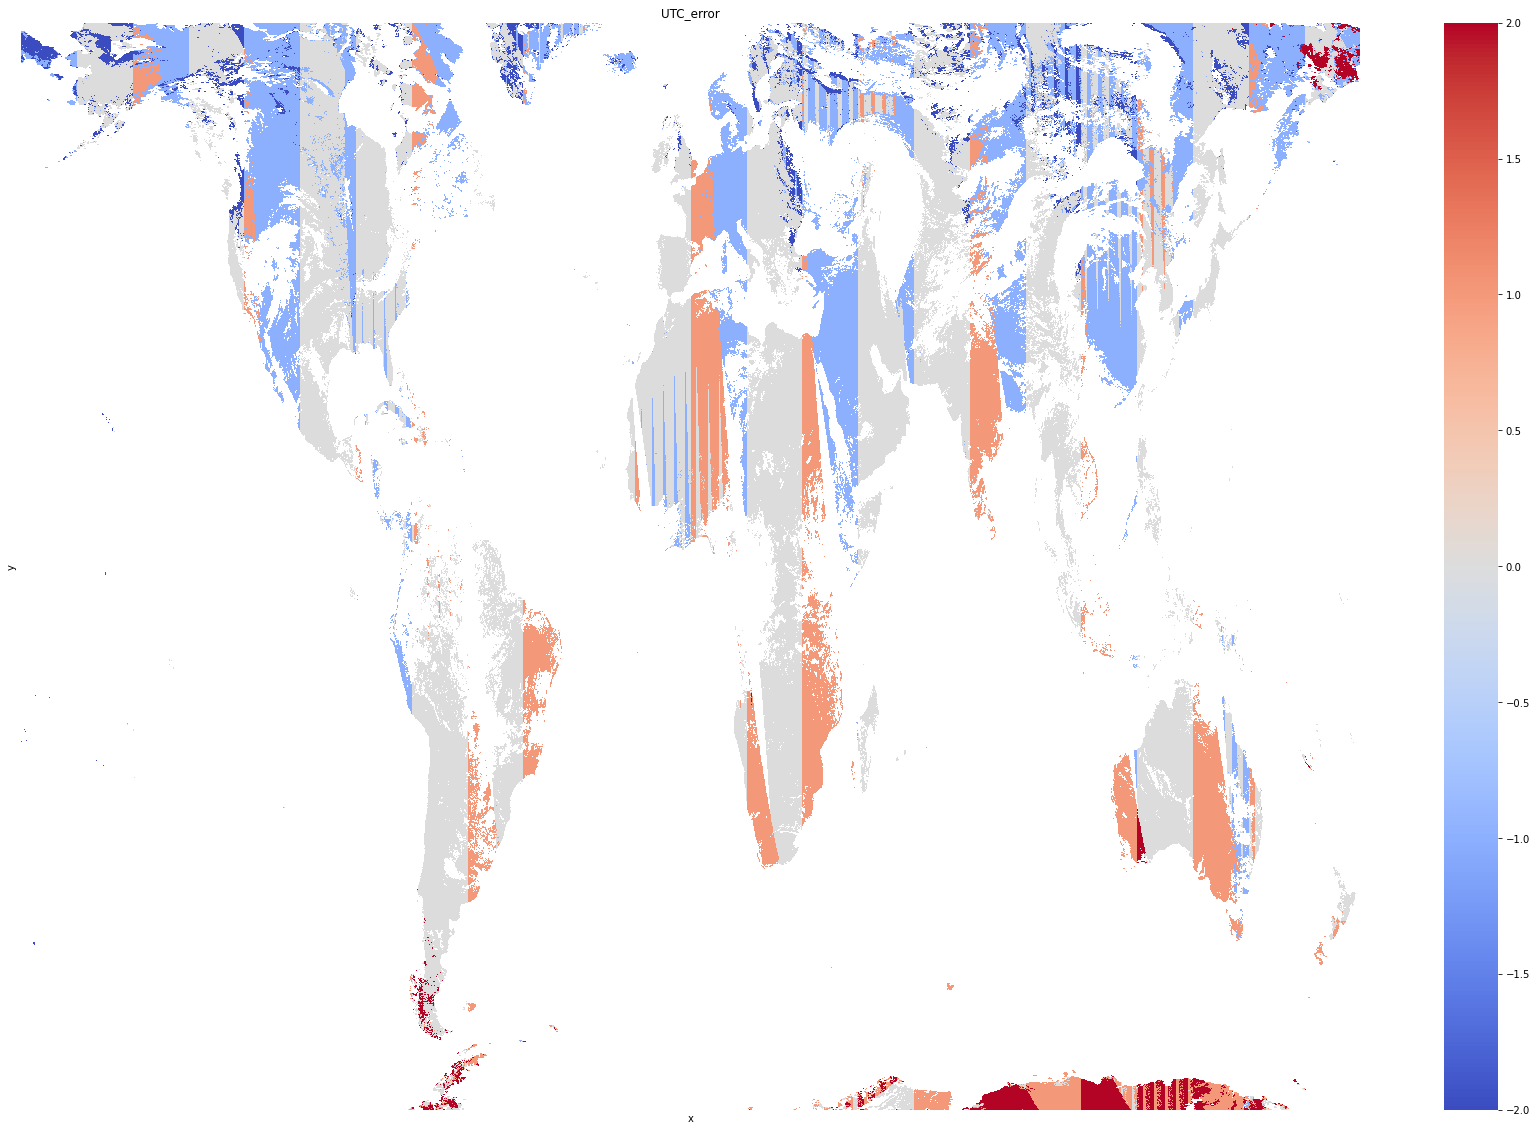

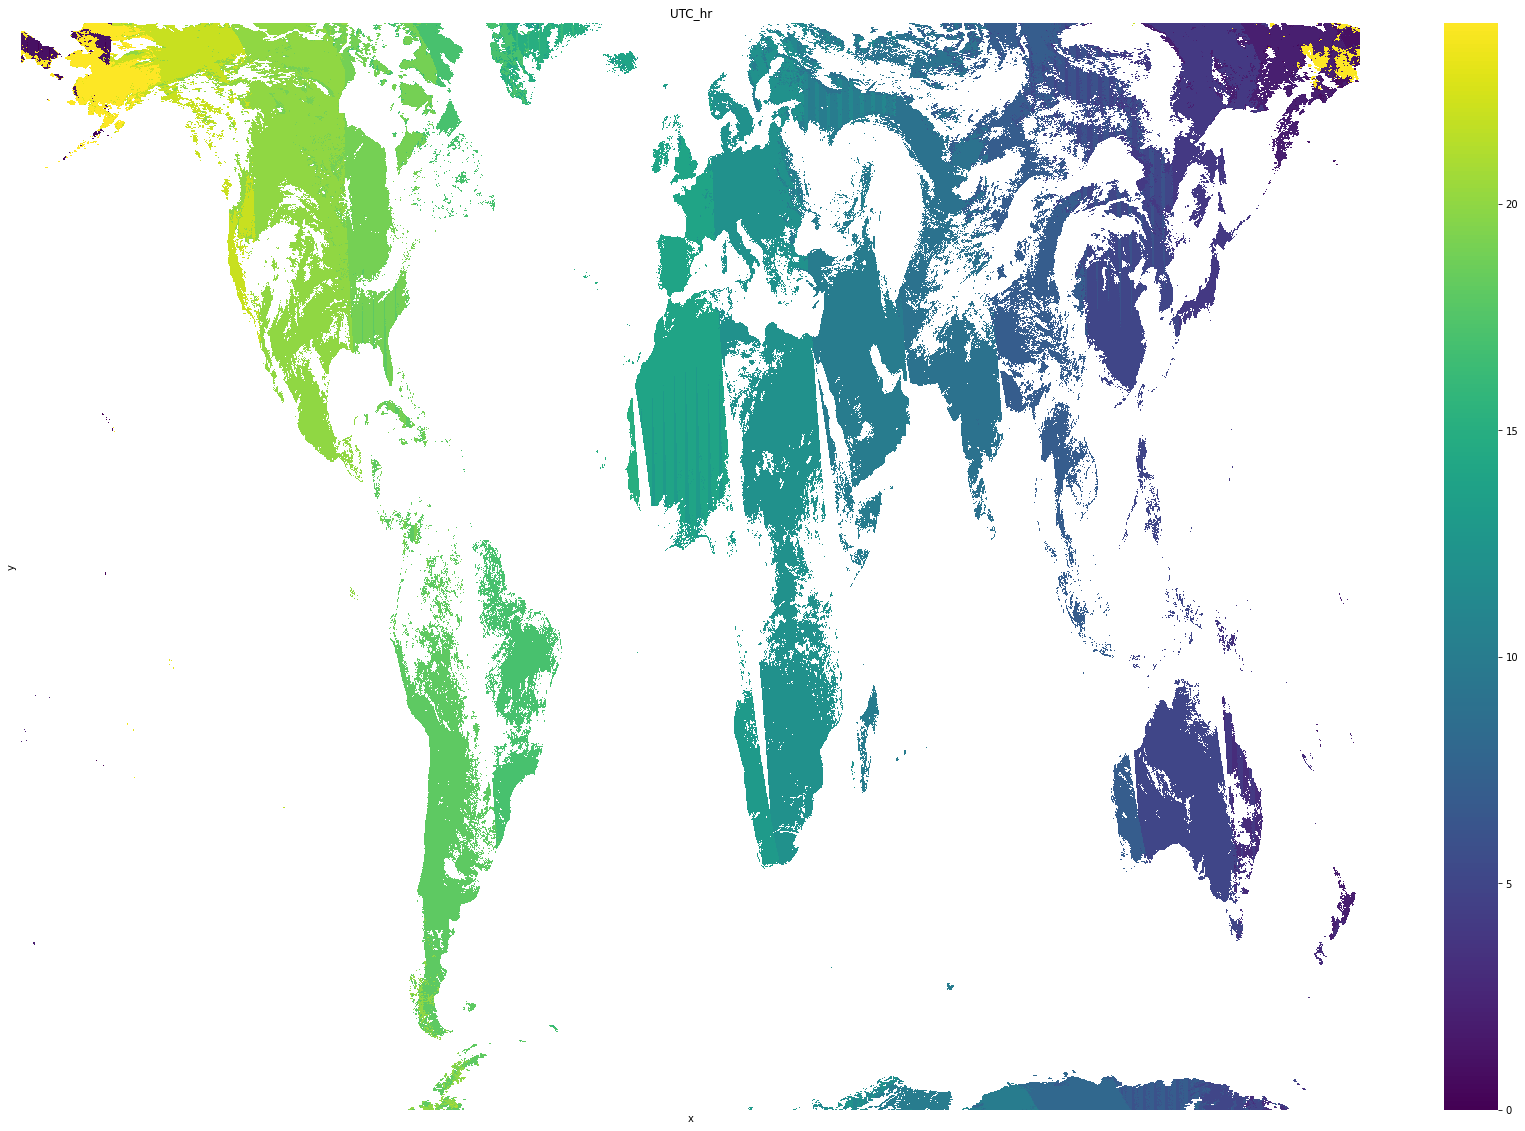

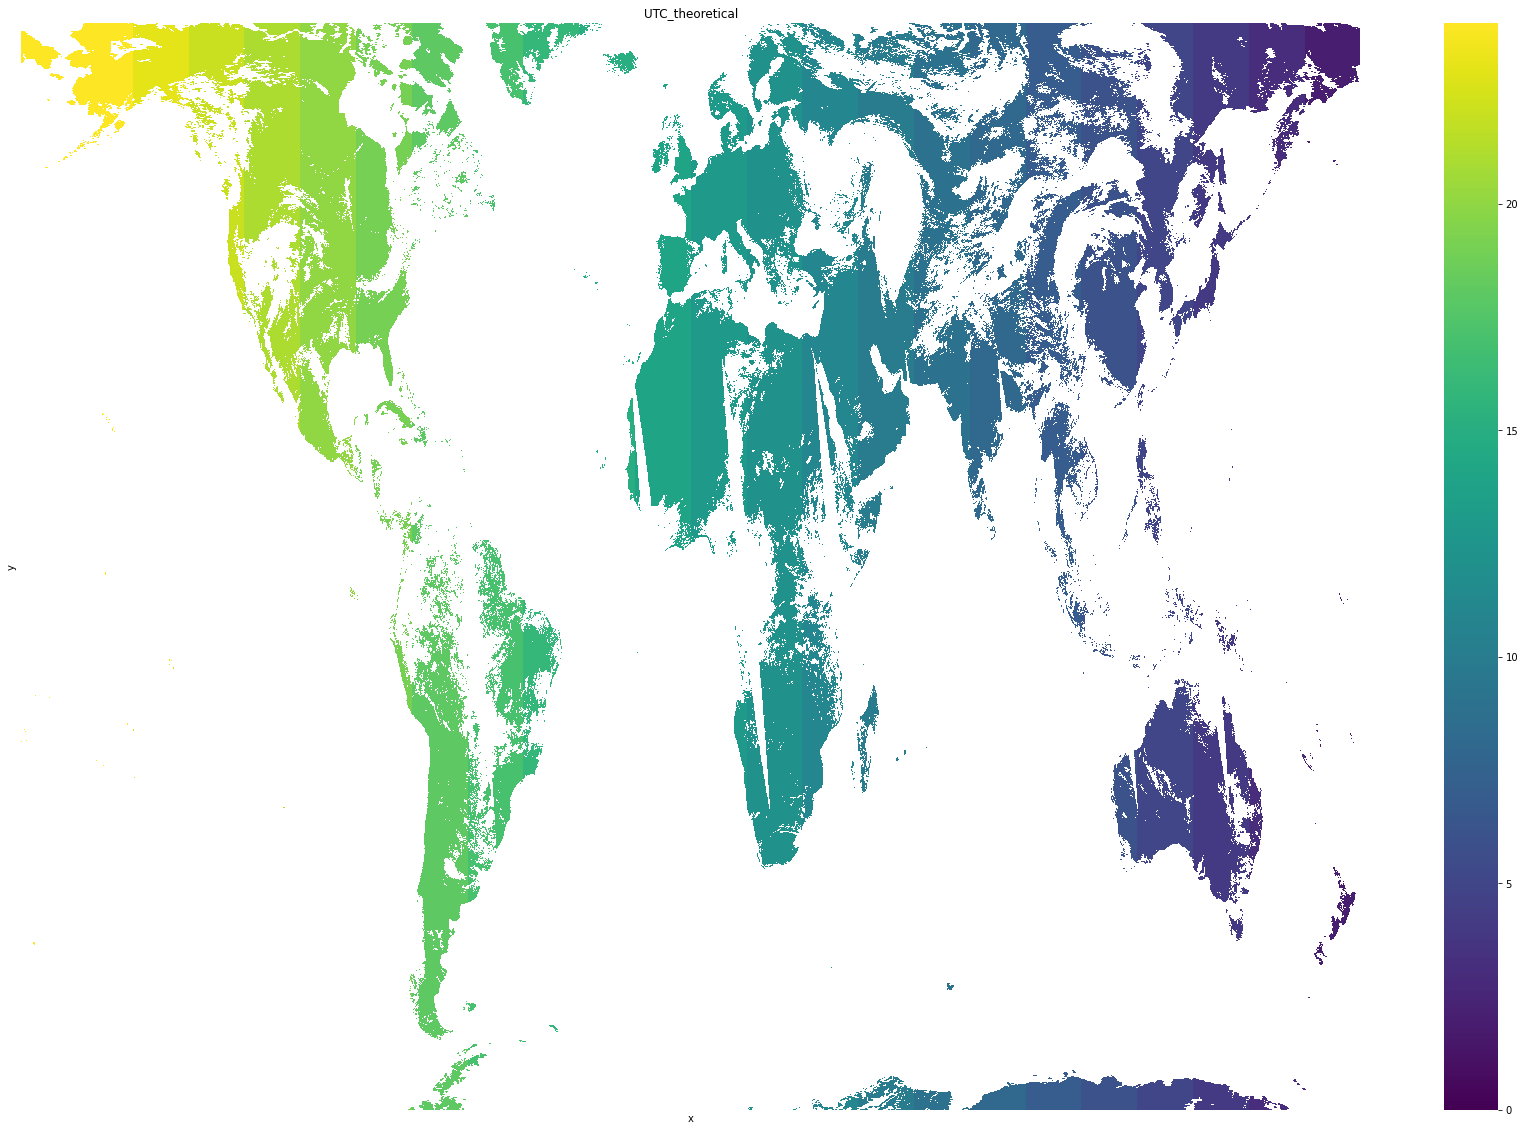

In [112]:
plot_heatmap(modis_df_lat70,'y','x','UTC_error',cmap="coolwarm", vmin=-2, vmax=2)
plot_heatmap(modis_df_lat70,'y','x','UTC_hr',cmap="viridis", vmin=0, vmax=24)
plot_heatmap(modis_df_lat70,'y','x','UTC_theoretical',cmap="viridis", vmin=0, vmax=24)

These look OK. Fair agreement between methods and no clear bias over problematic regions. 

### 1.4 Alternative time matching


To be sure, we can do our ERA-MODIS matching but using the `MYD11C1` product with exact times.


In [102]:
import numpy as np


#Path to ERA data
era_folder = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw'


def get_MODIS_alternative(date : str,
                          utc_hour : int,   
                          MYD_df
                          ):
    
    """
    An alternative MODIS function to load a time slice from a pre-downloaded data file MYD11C1 for 2018-04-19
    """
    
    
    if date != '2018-04-19':
        print('Exiting - only valid for 2018-04-19')
        return
    
    
   


    
    #Rename
    MYD_df = MYD_df.rename(columns={"x": "longitude", "y": "latitude","LST_Day_CMG": "MODIS_LST"})
    
    #Select on time
    MYD_df = MYD_df.query(f'UTC_hr == {utc_hour}')
    
    
    return MYD_df[['latitude', 'longitude', 'MODIS_LST']].reset_index()






def get_era_data(date : str,
                 utc_hour : str,
                 field : str,
                 bounds : dict,
                 source: str):

    """
    
       Used in main analysis pipeline
    
       Function to load hourly slice of ERA data 
       Additional filtering by max/min longitude, read from matching MODIS file
       
       
    """
        
    #Load the data
    month = '_'.join(date.split('-')[:-1])
    
    if source == 'ERA_skin':
        name = '_skin_'
    if source == 'ERA_sfc':
        name = '_'
        
    utc_0hour = f'{utc_hour:02}'
    fname = f'{era_folder}/{source}/NetCDF/{date}T{utc_0hour}:00:00.000000000.nc'
    ds_era = xr.open_dataset(fname)
    
        
    #Grab correct field
    if field is not None:
        da = ds_era[field]
    else:
        da = ds_era
    
     # Also filter by latitude/longtiude
    longitude_filter = (da.longitude > bounds['longitude_min']) & (da.longitude < bounds['longitude_max'])
    latitude_filter =  (da.latitude > bounds['latitude_min']) & (da.latitude < bounds['latitude_max'])
    
  
    da_filtered = da.where(longitude_filter & latitude_filter,drop=True)

    #Explictley close the file
    ds_era.close()
    
    return da_filtered


def filter_out_sea(ds : xr.Dataset):
    
    """
    Use lsm variable to filter out ocean values, retaining only land values
    Returns a pandas dataframe
    """
    
    df = ds.to_dataframe().reset_index()
    df_land = df.loc[df['lsm'] > 0.5]
    
    
    return df_land
    


def haver(lat1_deg,lon1_deg,lat2_deg,lon2_deg):
    
    """
    Given coordinates of two points IN DEGREES calculate the haversine distance
    """
    
    #Convert degrees to radians
    lat1 = np.deg2rad(lat1_deg)
    lon1 = np.deg2rad(lon1_deg)
    lat2 = np.deg2rad(lat2_deg)
    lon2 = np.deg2rad(lon2_deg)


    #...and the calculation
    delta_lat = lat1 -lat2
    delta_lon = lon1 -lon2
    Re = 6371 #km
    Z = np.sin(delta_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(delta_lon/2)**2
    H = 2*Re*np.arcsin(np.sqrt(Z)) #Haversine distance in km
    return H

    
    
import faiss

def faiss_knn(database,query):
    
    """
    Use faiss library (https://github.com/facebookresearch/faiss) for fass k-nearest neighbours on GPU
    
    Note that the nearness is an L2 (squared) norm on the lat/long coordinates, rather than a haversine metric
    
    For every MODIS point, match with the closest ERA point and then group by ERA lat/lon
    """
    
    #Database
    xb = database[["latitude", "longitude"]].to_numpy().astype('float32')
    xb = xb.copy(order='C') #C-contigious
    
    #Query
    xq = query[["latitude", "longitude"]].to_numpy().astype('float32') 
    xq = xq.copy(order='C')
    
    #Create index
    d = 2                            # dimension
    res = faiss.StandardGpuResources()
    index_flat = faiss.IndexFlatL2(d) #index
    gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat) # make it into a gpu index
    gpu_index_flat.add(xb)  
    
    #Search
    k = 1                          # we want to see 1 nearest neighbors
    distances, indices = gpu_index_flat.search(xq, k)
    

    #Combine into a single df with all data
    df = query.reset_index().join(database.iloc[indices.flatten()].reset_index(), lsuffix='_MODIS',rsuffix='_ERA')
    df['L2_distance'] = distances
    df['MODIS_idx'] = indices
    df['H_distance'] = haver(df['latitude_MODIS'],df['longitude_MODIS'],df['latitude_ERA'],df['longitude_ERA']) #Haversine distance
    
    #Filter out any large distances
    tolerance = 50 #km
    df_filtered = df.query('H_distance < %.9f' % tolerance)
    


    #Group it. Each ERA point has a bunch of MODIS points. Group and average
    df_grouped = df_filtered.groupby(['latitude_ERA','longitude_ERA'],as_index=False).mean()


    return df_grouped

In [145]:
def pipeline(date,utc_hour,MODIS_data):

    
    print (f'Running pipeline for date: {date} and hour: {utc_hour}')
    
    #1. MODIS
    print("Getting MODIS data")
    MODIS_df = get_MODIS_alternative(date,utc_hour,MODIS_data)
    
    
    
    #2. ERA


    #Spatial bounds to impose on the ERA dataset
    delta = 1.0
    bounds = {"latitude_min" :    MODIS_df.latitude.min()-delta,
              "latitude_max" :    MODIS_df.latitude.max()+delta,
              "longitude_min":    MODIS_df.longitude.min()-delta,
              "longitude_max":    MODIS_df.longitude.max()+delta
              }

    print("Getting ERA data within bounds:")
    print(bounds)
    fields = None #['t2m','v10'] #'None' selects all data variables. Selecting > 1 field returns a dataset rather than a data array
    ERA_sfc = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_sfc')
    ERA_skin = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_skin')
    ERA = xr.merge([ERA_sfc, ERA_skin])
    ERA_df_land = filter_out_sea(ERA)

    
    
    
    #3. Find matches
    print("Finding matches")
    df = faiss_knn(ERA_df_land,MODIS_df.dropna())   
    df['temperature_error'] = df.MODIS_LST - df.t2m
    
    return df
    
    
    
    
    

In [134]:

import pandas as pd
date = '2018-04-19'
dfs = []

for i in range(2,23):
    print(i)
    df = pipeline(date,i,modis_df_lat70)
    dfs.extend([df])
    
df_matches_alternative_time_method = pd.concat(dfs)

2
Running pipeline for date: 2018-04-19 and hour: 2
Getting MODIS data
find matches
3
Running pipeline for date: 2018-04-19 and hour: 3
Getting MODIS data
find matches
4
Running pipeline for date: 2018-04-19 and hour: 4
Getting MODIS data
find matches
5
Running pipeline for date: 2018-04-19 and hour: 5
Getting MODIS data
find matches
6
Running pipeline for date: 2018-04-19 and hour: 6
Getting MODIS data
find matches
7
Running pipeline for date: 2018-04-19 and hour: 7
Getting MODIS data
find matches
8
Running pipeline for date: 2018-04-19 and hour: 8
Getting MODIS data
find matches
9
Running pipeline for date: 2018-04-19 and hour: 9
Getting MODIS data
find matches
10
Running pipeline for date: 2018-04-19 and hour: 10
Getting MODIS data
find matches
11
Running pipeline for date: 2018-04-19 and hour: 11
Getting MODIS data
find matches
12
Running pipeline for date: 2018-04-19 and hour: 12
Getting MODIS data
find matches
13
Running pipeline for date: 2018-04-19 and hour: 13
Getting MODIS da

In [136]:
import matplotlib.colors as mc
import matplotlib.colorbar as cb  
def plot_scattermap(df,z,vmin,vmax,cmap):
    
    #Get all data as vectors
    x = df.longitude_ERA
    y = df.latitude_ERA
    z1 = df[z]
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z1)),
               linewidths=1, alpha=.7
               )

    ax.set_title(z)
    
    ax.set_xlim(-150,150)
    plt.show()
    
    

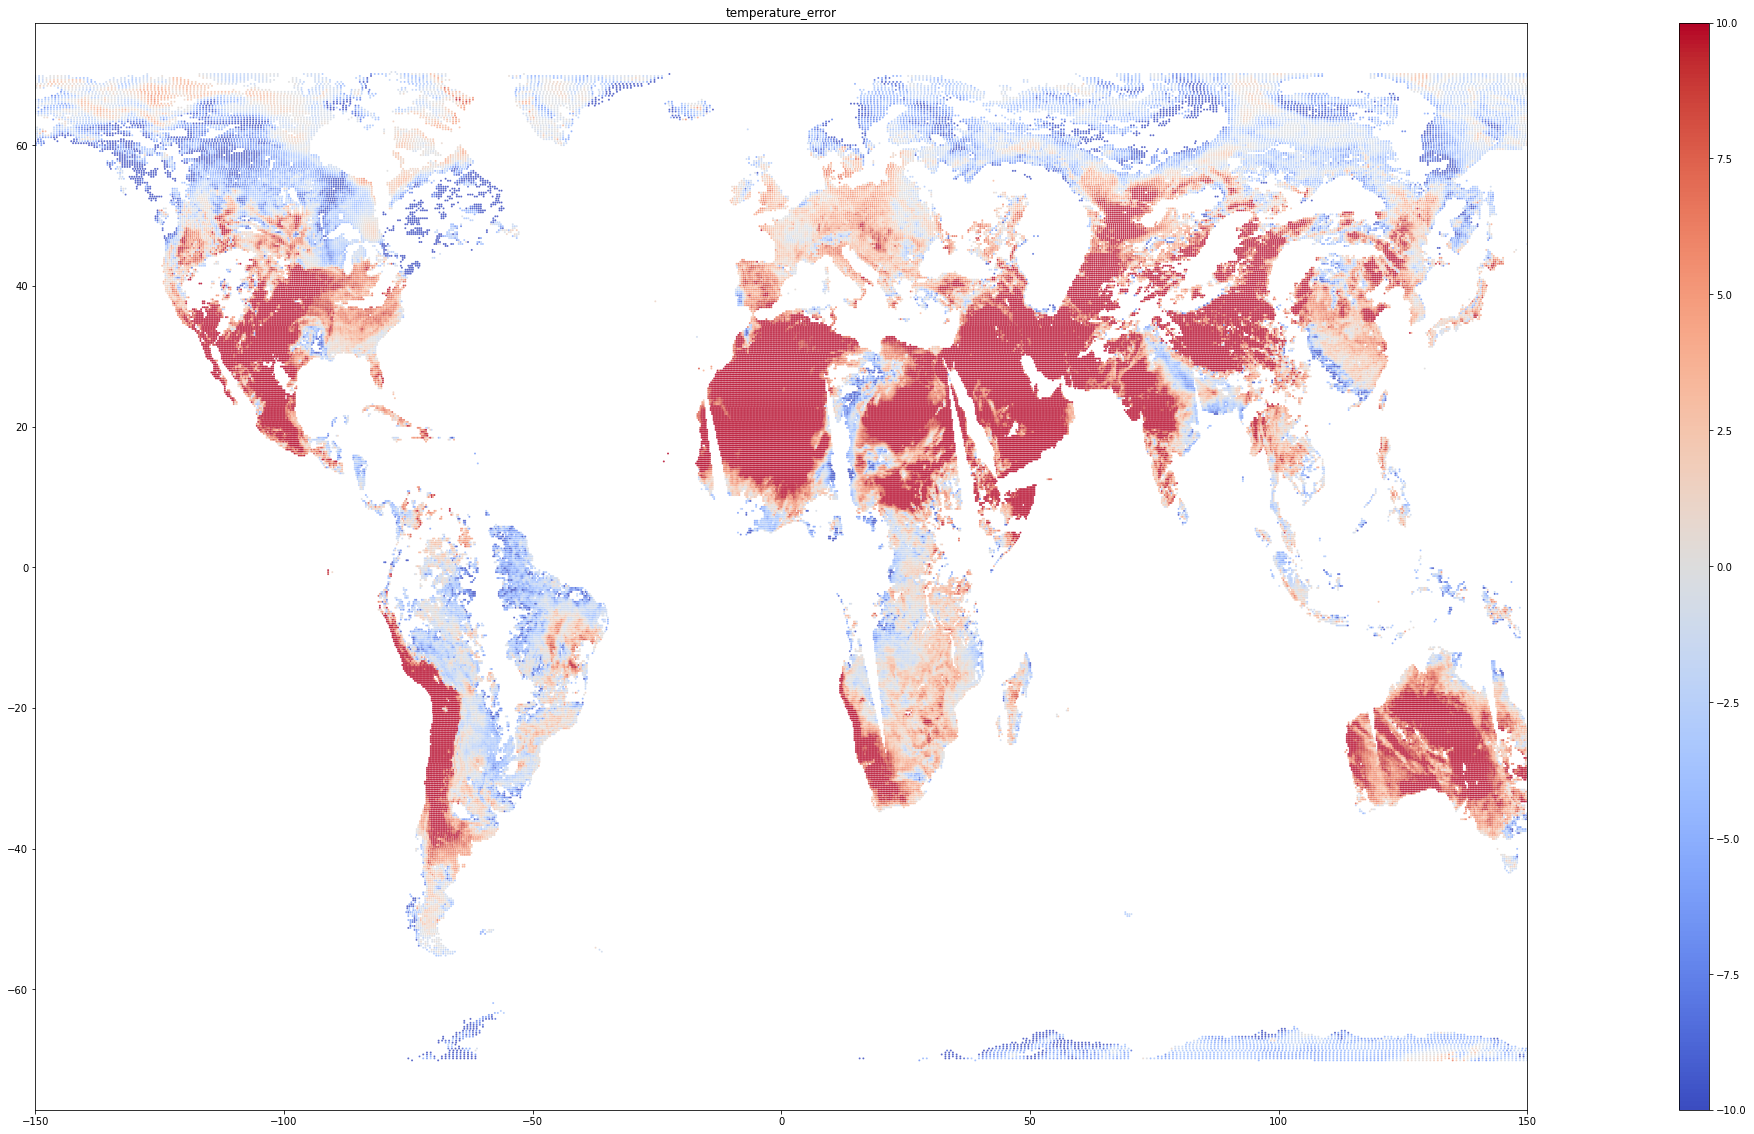

In [138]:
#Note there may be some overlap between points in df_matches_alternative_time_method, os useful to groupby first


df_matches_alternative_time_method_grouped = df_matches_alternative_time_method.groupby(['latitude_ERA','longitude_ERA'],as_index=False).mean()
plot_scattermap(df_matches_alternative_time_method_grouped,'temperature_error', vmin=-10, vmax=+10, cmap=plt.cm.coolwarm)

We can see the same problem areas even for just a 24 hour period, using the correct time

**Hypothesis 1 fails**


---


## 2. Hypothesis 2

**Low quality MODIS data is introducing an error**


Our new `MYD` dataset also has a variable `QC_Day` variable which is an interpretable bit string that defines the data quality. See section 5.4 of https://lpdaac.usgs.gov/documents/715/MOD11_User_Guide_V61.pdf.

How does the data quality vary spatially? Could this be the bias source?


### 2.1 Prepare the data
Similar to Hypothesis 1 section, but we now also include the `QC_Day` var.


In [147]:
def convert_to_bit_string(x):
    
    s = int(x)
    
    return f'0b{s:08b}'

#Dataframe
modis_df = modis_xarray[['LST_Day_CMG','Day_view_time','QC_Day']].to_dataframe().reset_index().dropna().drop(['band','spatial_ref'],axis=1)

#Quality as a bit string
modis_df['bit_string'] =  modis_df['QC_Day'].apply(convert_to_bit_string)

#Read the bit string. See docs
modis_df['QA_flags'] = modis_df['bit_string'].apply(lambda x: x[2:4])
modis_df['DQ_flags'] = modis_df['bit_string'].apply(lambda x: x[4])
modis_df['CU_flags'] = modis_df['bit_string'].apply(lambda x: x[5])
modis_df['Emis_flags'] = modis_df['bit_string'].apply(lambda x: x[6:8])
modis_df['LST_flags'] = modis_df['bit_string'].apply(lambda x: x[8:10])
modis_df['UTC_hr']    = round(modis_df.Day_view_time) #needed for time selection

We can select just the high quality data, also applying the latitude cutoffs. Here high quality means average LST error <= 1K

In [148]:
modis_df_lat70_HQ = modis_df.query('-70 < y < 70 & LST_flags == "00" & DQ_flags == "0"')
modis_df_lat70_LQ = modis_df.query('-70 < y < 70 ') #low quality or all data

### 2.2 Quick look

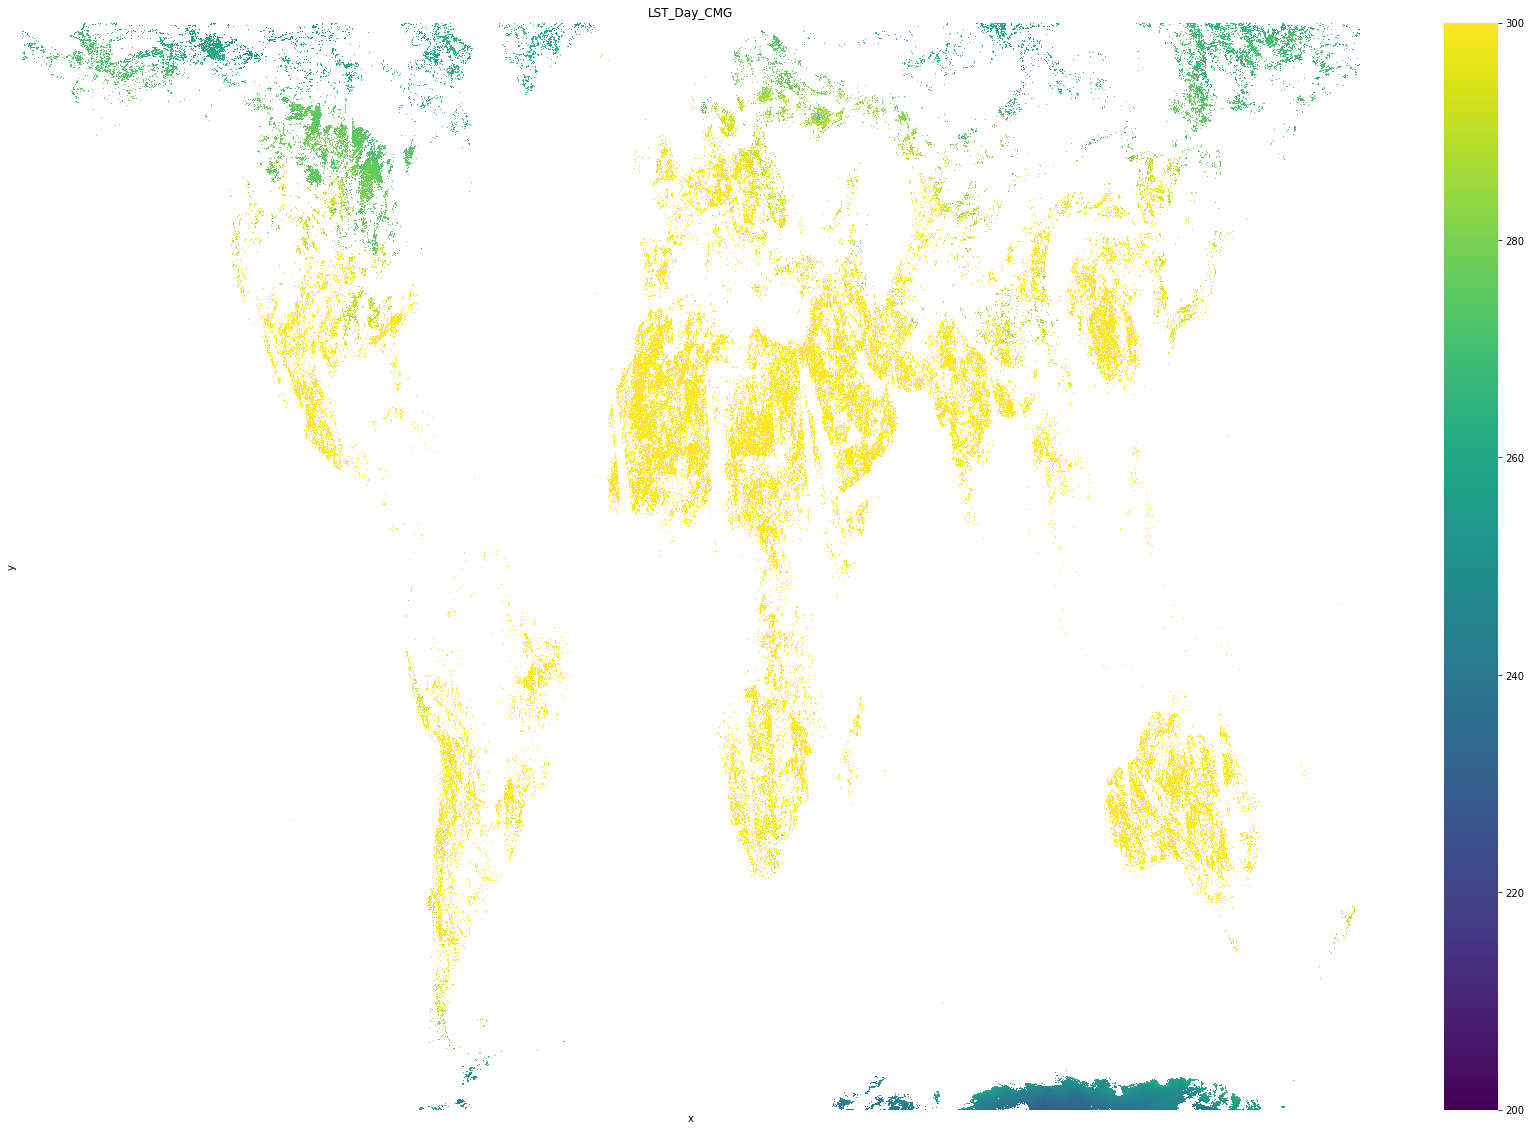

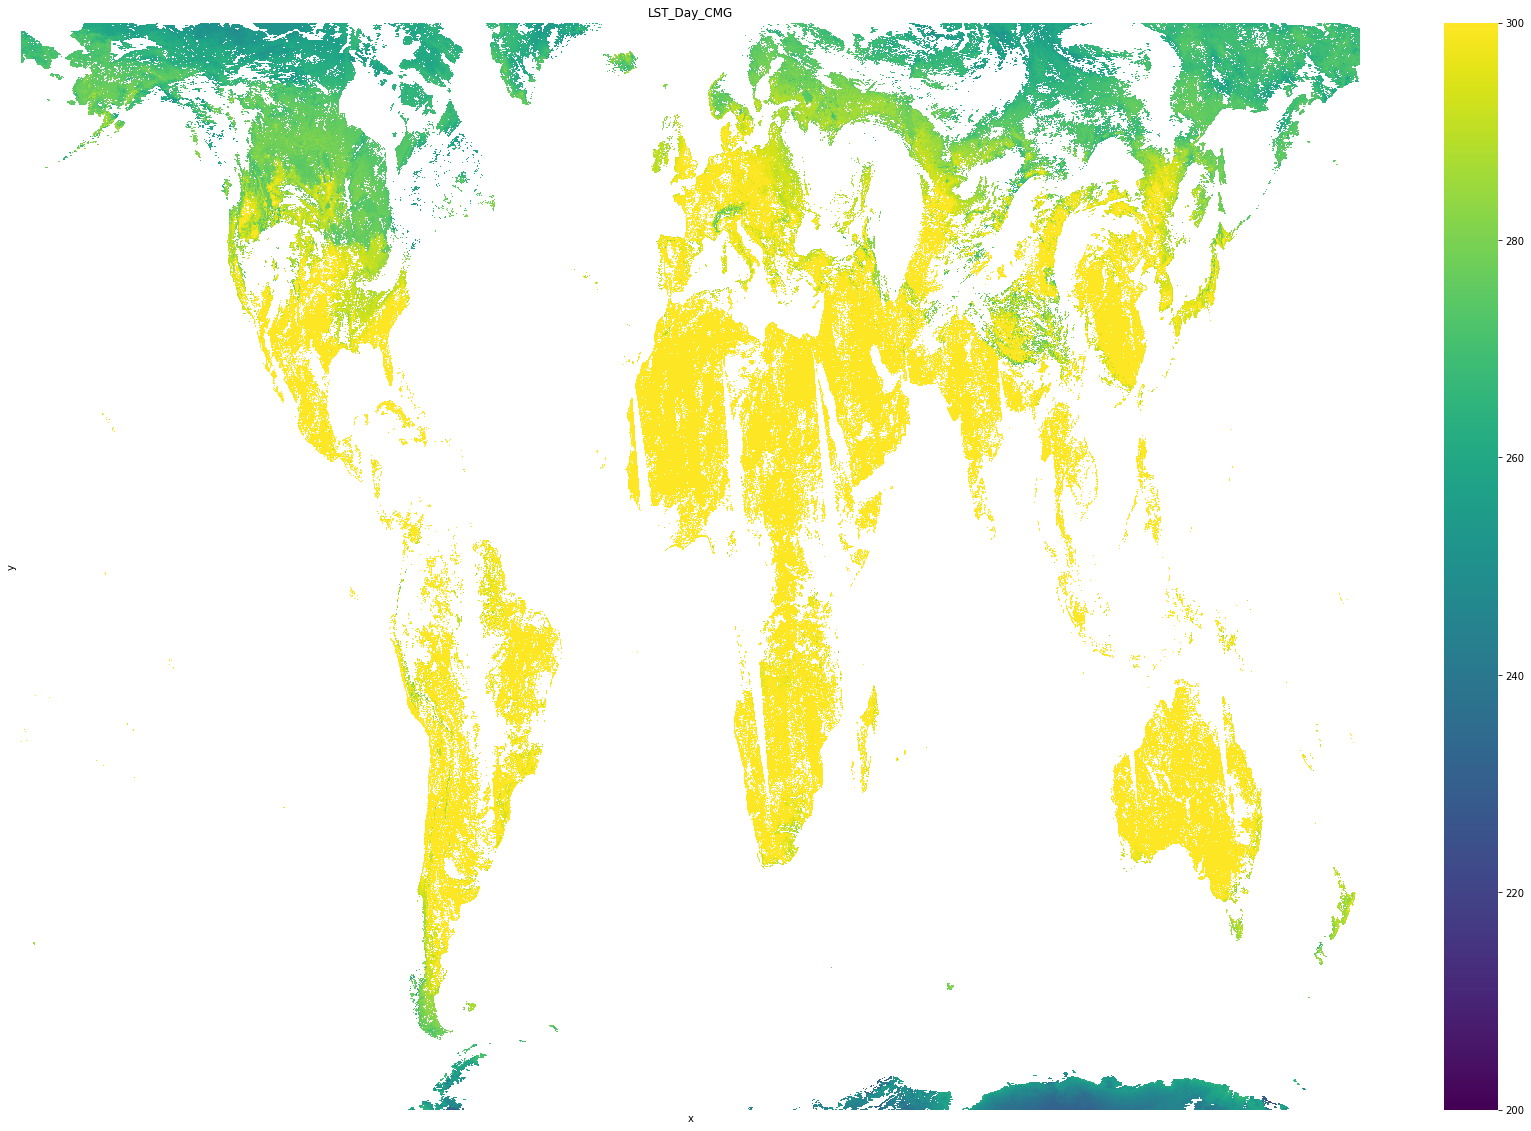

In [149]:
plot_heatmap(modis_df_lat70_HQ,'y','x','LST_Day_CMG',cmap="viridis", vmin=200, vmax=300)
plot_heatmap(modis_df_lat70_LQ,'y','x','LST_Day_CMG',cmap="viridis", vmin=200, vmax=300)

Clearly there is less data in the high qualty case, but there is no apparent spatial dependence. 


### 2.3 Matching just using HQ data


To be certain this has no impact on the bias, we can again perform the matching, but using the more sparse HQ dataset.

In [150]:
import pandas as pd
date = '2018-04-19'
dfs = []

for i in range(2,23):
    print(i)
    df = pipeline(date,i,modis_df_lat70_HQ)
    dfs.extend([df])
    
df_matches_alternative_quality_method = pd.concat(dfs)

2
Running pipeline for date: 2018-04-19 and hour: 2
Getting MODIS data
Getting ERA data within bounds:
{'latitude_min': -44.82500000000002, 'latitude_max': 70.975, 'longitude_min': -177.575, 'longitude_max': 179.72500000000005}
Finding matches
3
Running pipeline for date: 2018-04-19 and hour: 3
Getting MODIS data
Getting ERA data within bounds:
{'latitude_min': -70.62500000000003, 'latitude_max': 59.02499999999999, 'longitude_min': 139.525, 'longitude_max': 175.17500000000004}
Finding matches
4
Running pipeline for date: 2018-04-19 and hour: 4
Getting MODIS data
Getting ERA data within bounds:
{'latitude_min': -70.97500000000002, 'latitude_max': 70.975, 'longitude_min': 95.975, 'longitude_max': 167.37500000000003}
Finding matches
5
Running pipeline for date: 2018-04-19 and hour: 5
Getting MODIS data
Getting ERA data within bounds:
{'latitude_min': -70.97500000000002, 'latitude_max': 70.975, 'longitude_min': 69.57500000000002, 'longitude_max': 163.72500000000005}
Finding matches
6
Runni

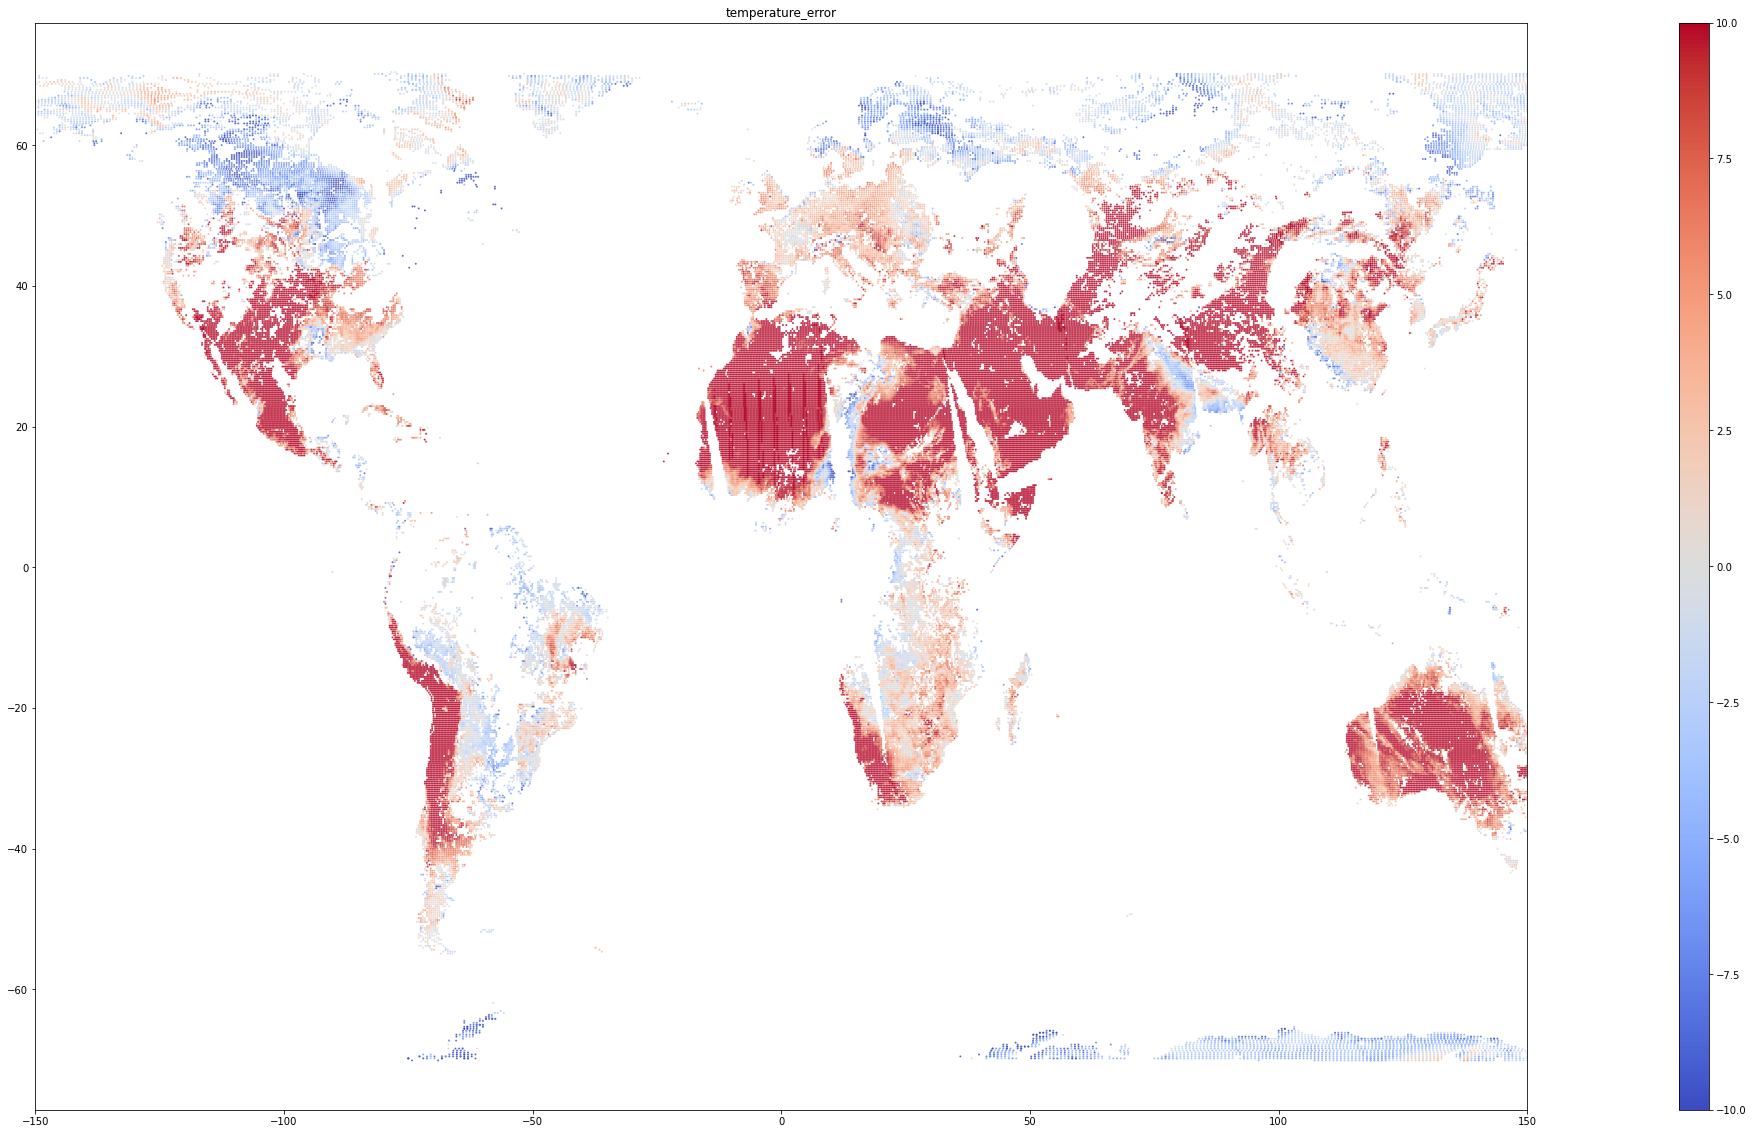

In [151]:
plot_scattermap(df_matches_alternative_quality_method,'temperature_error', vmin=-10, vmax=+10, cmap=plt.cm.coolwarm)

We can see the same problem areas

**Hypothesis 2 fails**


---


## 2. Hypothesis 3

**Alternative dataset**






# Dictionaries, configs, imports

In [2]:
import xarray as xr
import rioxarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors


#These dictionaries describe the local hour of the satellite
local_times = {"aquaDay":"13:30",
               "terraDay":"10:30",
               "terraNight":"22:30",
               "aquaNight":"01:30"
              }
# and are used to load the correct file for dealing with the date-line.
min_hours = {"aquaDay":2,
            "terraDay":-1,
            "aquaNight":-1,
            "terraNight":11}
max_hours = {"aquaDay":24,
            "terraDay":22,
            "aquaNight":13,
            "terraNight":24}


#Path to MODIS data
satellite_folder = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/MODIS/'






# Functions

In [48]:




# def get_MODIS_alternative(date : str,
#                           utc_hour : int,
#                           satellite : str,
#                           latitude_bound = None #Recommend only using |lat| < 70 degrees
#                           ):
    
#     """
#     An alternative MODIS function to load a pre-downloaded data file
#     """
    
    
#     if date != '2018-04-19':
#         print('Exiting - only valid for 2018-04-19')
#         return
    
    
#     #Load the data
#     modis_xarray= rioxarray.open_rasterio('/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/example_MODIS_data.hdf',masked=True)


#     #Make it a nice df
#     modis_df = modis_xarray[['LST_Day_CMG','Day_view_time','QC_Day']].to_dataframe().reset_index().dropna().drop(['band','spatial_ref'],axis=1)


#     #Create some new columns
#     modis_df['temperature_kelvin'] = modis_df['LST_Day_CMG']*modis_xarray.LST_Day_CMG.scale_factor
#     modis_df['UTC'] = round(modis_df['Day_view_time']*modis_xarray.Day_view_time.scale_factor)
#     #modis_df['UTC'] = round(13.5 - modis_df.x/15)


    
#     #Rename
#     modis_df = modis_df.rename(columns={"x": "longitude", "y": "latitude"})
#     #Select on time and longitude
#     modis_df = modis_df.query(f'UTC == {utc_hour} & -{latitude_bound} < latitude < {latitude_bound}')
    
    
#     return modis_df









# def get_satellite_slice(date : str,
#                         utc_hour : int,
#                         satellite : str,
#                         latitude_bound = None #Recommend only using |lat| < 70 degrees
#                         ):
    
#     """Function to load hourly slice of MODIS data from Mat Chantry.
#        Some naming changes from original, logic mostly unchanged.
#        We now drop coordinates that are filtered out"""
    
#     #Due to crossing of the datetime, some times will be saved different date
#     if utc_hour < min_hours[satellite]:
#         file_date = str((np.datetime64(date) - np.timedelta64(1,'D')))
#     elif utc_hour > max_hours[satellite]:
#         file_date = str((np.datetime64(date) + np.timedelta64(1,'D')))
#     else:
#         file_date = date
        
#     print(file_date)
#     # Open .tif 
#     #sat_xr = xr.open_rasterio(f'{satellite_folder}/{satellite}_errorGTE03K_04km_{file_date}.tif')
#     sat_xr = xr.open_dataarray(f'{satellite_folder}/{satellite}_errorGTE03K_04km_{file_date}.tif',engine="rasterio")

#     # Rename spatial dimensions
#     sat_xr = sat_xr.rename({'x':'longitude','y':'latitude'})
    
#     #Create time delta to change local to UTC
#     time_delta = pd.to_timedelta(sat_xr.longitude.data/15,unit='H') 
    
#     #Convert local satellite time to UTC and round to nearest hour
#     time = (pd.to_datetime([file_date + " " + local_times[satellite]]*time_delta.shape[0]) - time_delta).round('H')
    
#     #What date/time does the user want?
#     target_time = np.datetime64(f'{date} {utc_hour:02}:00:00')
        
#     #Is this target time in this data array?
#     time_filter = np.expand_dims(time == target_time,axis=(0,1))
    
#     # Make this 1d time filter a 2d mask
#     mask = np.logical_and(np.isfinite(sat_xr),time_filter)
    
#     # Also filter by latitude
#     space_filter = np.expand_dims(np.abs(sat_xr.latitude) < latitude_bound,axis=(0,-1))
    
#     #...and add this condition to the mask
#     mask = np.logical_and(mask,space_filter)
    
    
#     #Check we have some true values in our mask
#     if mask.sum() == 0:
#         print('There is no appropriate data')
#         return 0
      
#     #Apply mask to data array
#     sat_xr_filtered= sat_xr.where(mask,drop=True).load() 
    
     
#     #Close
#     sat_xr.close()
#     sat_xr = None
    
    
   
#     return sat_xr_filtered[0,::-1,:]





    



    

    
    




    
    
    

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
        
        
        

def plot_map(ds,x,y,q): #slow plotting function

    #Takes a ds, converts to pandas df
    
    if isinstance(ds, pd.DataFrame):
        df = ds
    else:
        df = ds.to_dataframe().reset_index()#.dropna()
        
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]))
    
    #Plot the world
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world.boundary.plot(figsize=(24,12))
    
    gdf.plot(ax=ax,column=q,cmap='plasma',markersize=1,legend=True)
    
    plt.show()
    
import matplotlib.colors as mc
import matplotlib.colorbar as cb  
def plot_error(df,z,vmin,vmax,cmap):
    
    #Get all data as vectors
    x = df.longitude_ERA
    y = df.latitude_ERA
    z1 = df[z]
    
    #Scatter plot it
    # init the figure
    fig,[ax,cax] = plt.subplots(1,2, gridspec_kw={"width_ratios":[50,1]},figsize=(30, 20))

    
    norm = mc.Normalize(vmin=vmin, vmax=vmax)

    cb1 = cb.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
    
    
    sc = ax.scatter(x, y,
               s=1,
               c=cmap(norm(z1)),
               linewidths=1, alpha=.7
               )

    ax.set_title(z)
    
    ax.set_xlim(-150,150)
    plt.show()
    
    
    
    
    
    
    
    
def faiss_knn_swp(database,query):
    
    """
    Copy of above function, swapped and without grouping.
    i.e. for every ERA point, get the single closest MODIS point

    """
    
    #Database
    xb = database[["latitude", "longitude"]].to_numpy().astype('float32')
    xb = xb.copy(order='C') #C-contigious
    
    #Query
    xq = query[["latitude", "longitude"]].to_numpy().astype('float32') 
    xq = xq.copy(order='C')
    
    #Create index
    d = 2                            # dimension
    res = faiss.StandardGpuResources()
    index_flat = faiss.IndexFlatL2(d) #index
    gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat) # make it into a gpu index
    gpu_index_flat.add(xb)  
    
    #Search
    k = 1                          # we want to see 1 nearest neighbors
    distances, indices = gpu_index_flat.search(xq, k)
    

    #Combine into a single df with all data
    df = query.reset_index().join(database.iloc[indices.flatten()].reset_index(), lsuffix='_ERA',rsuffix='_MODIS')
    df['L2_distance'] = distances
    df['MODIS_idx'] = indices
    df['H_distance'] = haver(df['latitude_MODIS'],df['longitude_MODIS'],df['latitude_ERA'],df['longitude_ERA']) #Haversine distance
    
    
    #Filter out any large distances
    tolerance = 50 #km
    df_filtered = df.query('H_distance < %.9f' % tolerance)


  

    
    return df_filtered



  
    
    
    
    
    

In [83]:
def convert_to_bit_string(x):
    
    s = int(x)
    
    return f'0b{s:08b}'










def pipeline(date,utc_hour,MODIS_source,quality_filter):
    
    
    #1. Get MODIS data
    
    if MODIS_source == 'original':
        #MODIS
        MODIS = get_satellite_slice(date=date,utc_hour=utc_hour,satellite='aquaDay',latitude_bound=70)
        MODIS_df = MODIS.to_dataframe(name='MODIS_LST').reset_index().dropna()
        



        
    if MODIS_source == 'new':
        M = get_MODIS_alternative(date=date,utc_hour=utc_hour,satellite='aquaDay',latitude_bound=70)
        M = M.reset_index().drop(['LST_Day_CMG','Day_view_time','UTC'],axis=1)
        M = M.rename(columns={"temperature_kelvin": "MODIS_LST"})
        MODIS_df = M.dropna() #rename
        
        
        if quality_filter:
            print('Applying quality filter')
            MODIS_df['bit_string'] =  MODIS_df['QC_Day'].apply(convert_to_bit_string)
            MODIS_df['DQ_flags'] = MODIS_df['bit_string'].apply(lambda x: x[4])
            MODIS_df['LST_flags'] = MODIS_df['bit_string'].apply(lambda x: x[8:10])
            MODIS_df = MODIS_df.query('LST_flags == "00" & DQ_flags == "0"')



    #2. Get ERA data
    print('Getting ERA data')
    
    delta = 1.0
    bounds = {"latitude_min" :    MODIS_df.latitude.min()-delta,
              "latitude_max" :    MODIS_df.latitude.max()+delta,
              "longitude_min":    MODIS_df.longitude.min()-delta,
              "longitude_max":    MODIS_df.longitude.max()+delta
              }
    
    print(bounds)
    fields = None #['t2m','v10'] #'None' selects all data variables. Selecting > 1 field returns a dataset rather than a data array
    print('ERA_sfc')
    ERA_sfc = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_sfc')
    print('ERA_skin')
    ERA_skin = get_era_data(date = date,utc_hour=utc_hour,field=fields,bounds=bounds,source='ERA_skin')
    print('ERA_merge')
    ERA = xr.merge([ERA_sfc, ERA_skin])
    print('ERA_filter')
    ERA_df_land = filter_out_sea(ERA)

        

    #3. Find matches
    print("find matches")
    df = faiss_knn(ERA_df_land,MODIS_df.dropna())   
    df['temperature_error'] = df.MODIS_LST - df.t2m
    df['temperature_error_abs'] = abs(df.MODIS_LST - df.t2m)


    
    return df

First lets match a day of data using the usual method:

In [41]:
%%time
date = '2018-04-19'
#utc_hour = 14
dfs = []

for i in range(2,23):
    print(i)
    df = pipeline(date,i,'original')
    dfs.extend([df])
    
df1 = pd.concat(dfs)

2
2018-04-19
find matches
3
2018-04-19
find matches
4
2018-04-19
find matches
5
2018-04-19
find matches
6
2018-04-19
find matches
7
2018-04-19
find matches
8
2018-04-19
find matches
9
2018-04-19
find matches
10
2018-04-19
find matches
11
2018-04-19
find matches
12
2018-04-19
find matches
13
2018-04-19
find matches
14
2018-04-19
find matches
15
2018-04-19
find matches
16
2018-04-19
find matches
17
2018-04-19
find matches
18
2018-04-19
find matches
19
2018-04-19
find matches
20
2018-04-19
find matches
21
2018-04-19
find matches
22
2018-04-19
find matches
CPU times: user 2min 23s, sys: 5.73 s, total: 2min 28s
Wall time: 2min 33s


In [42]:
df1

latitude_ERA  longitude_ERA    index_MODIS  latitude_MODIS  \
0       -46.510520        169.125    2777.333333      -46.420370   
1       -46.510520        169.500    2496.625000      -46.447222   
2       -46.229490        169.125    4573.058824      -46.287255   
3       -46.229490        169.500    5157.681818      -46.244697   
4       -46.229490        169.875    4376.772727      -46.303030   
...            ...            ...            ...             ...   
1411     69.836018       -130.500  471032.506329       69.864768   
1412     69.836018       -128.250  470687.760736       69.834049   
1413     69.836018       -127.500  470779.375723       69.839210   
1414     69.836018       -124.500  470964.036364       69.846667   
1415     70.117048       -127.500  472716.500000       69.983333   

      longitude_MODIS  band  spatial_ref   MODIS_LST  index_ERA   values  ...  \
0          169.261111   1.0          0.0  283.063660    19772.0  19772.0  ...   
1          169.487500   1.0          0.0  281.609222    19773.0  19773.0  ...   
2          169.216667   1.0          0.0  282.681610    19730.0  19730.0  ...   
3          169.553030   1.0          0.0  285.748749    19731.0  19731.0  ...   
4          169.772727   1.0          0.0  283.441589    19732.0  19732.0  ...   
...               ...   ...          ...         ...        ...      ...  ...   
1411      -130.545359   1.0          0.0  250.936142       93.0     93.0  ...   
1412      -128.213395   1.0          0.0  249.417679       96.0     96.0  ...   
1413      -127.481985   1.0          0.0  249.517731       97.0     97.0  ...   
1414      -124.682121   1.0          0.0  252.308838      101.0    101.0  ...   
1415      -127.766667   1.0          0.0  249.752609       74.0     74.0  ...   

          anor      slor         d2m       lsm       fal  L2_distance  \
0     1.533608  0.013311  280.870667  0.989355  0.133231     0.028429   
1     1.430566  0.013112  280.339417  0.774381  0.103781     0.024495   
2    -0.075091  0.015641  280.347229  1.000000  0.189475     0.019416   
3     1.139772  0.016265  280.370667  0.995550  0.187369     0.022017   
4    -0.018308  0.011667  280.884338  0.829945  0.119360     0.026012   
...        ...       ...         ...       ...       ...          ...   
1411  0.291723  0.000914  249.216492  0.623911  0.609892     0.054366   
1412  0.514823  0.003904  248.064148  0.931557  0.581526     0.056461   
1413 -0.602331  0.003652  247.691101  0.996684  0.412718     0.058255   
1414  0.137756  0.003012  246.144226  0.566246  0.181395     0.056481   
1415  0.948756  0.003932  247.644226  0.959995  0.627989     0.092773   

      MODIS_idx  H_distance  temperature_error  temperature_error_abs  
0        1043.0   14.788865          -4.145355               4.145355  
1        1044.0   13.372106          -6.539246               6.539246  
2        1038.0   12.260197          -4.668030               4.668030  
3        1039.0   13.167332          -2.294250               2.294250  
4        1040.0   13.893718          -5.673676               5.673676  
...         ...         ...                ...                    ...  
1411        3.0   11.276233          -2.068817               2.068817  
1412        4.0   11.415743          -2.581421               2.581421  
1413        5.0   11.173036          -2.813400               2.813400  
1414        6.0   11.397787          -0.127762               0.127762  
1415        1.0   18.072948          -1.609772               1.609772  

[101686 rows x 40 columns]

Mean absolute error: 6.619544
Median absolute error: 4.934326


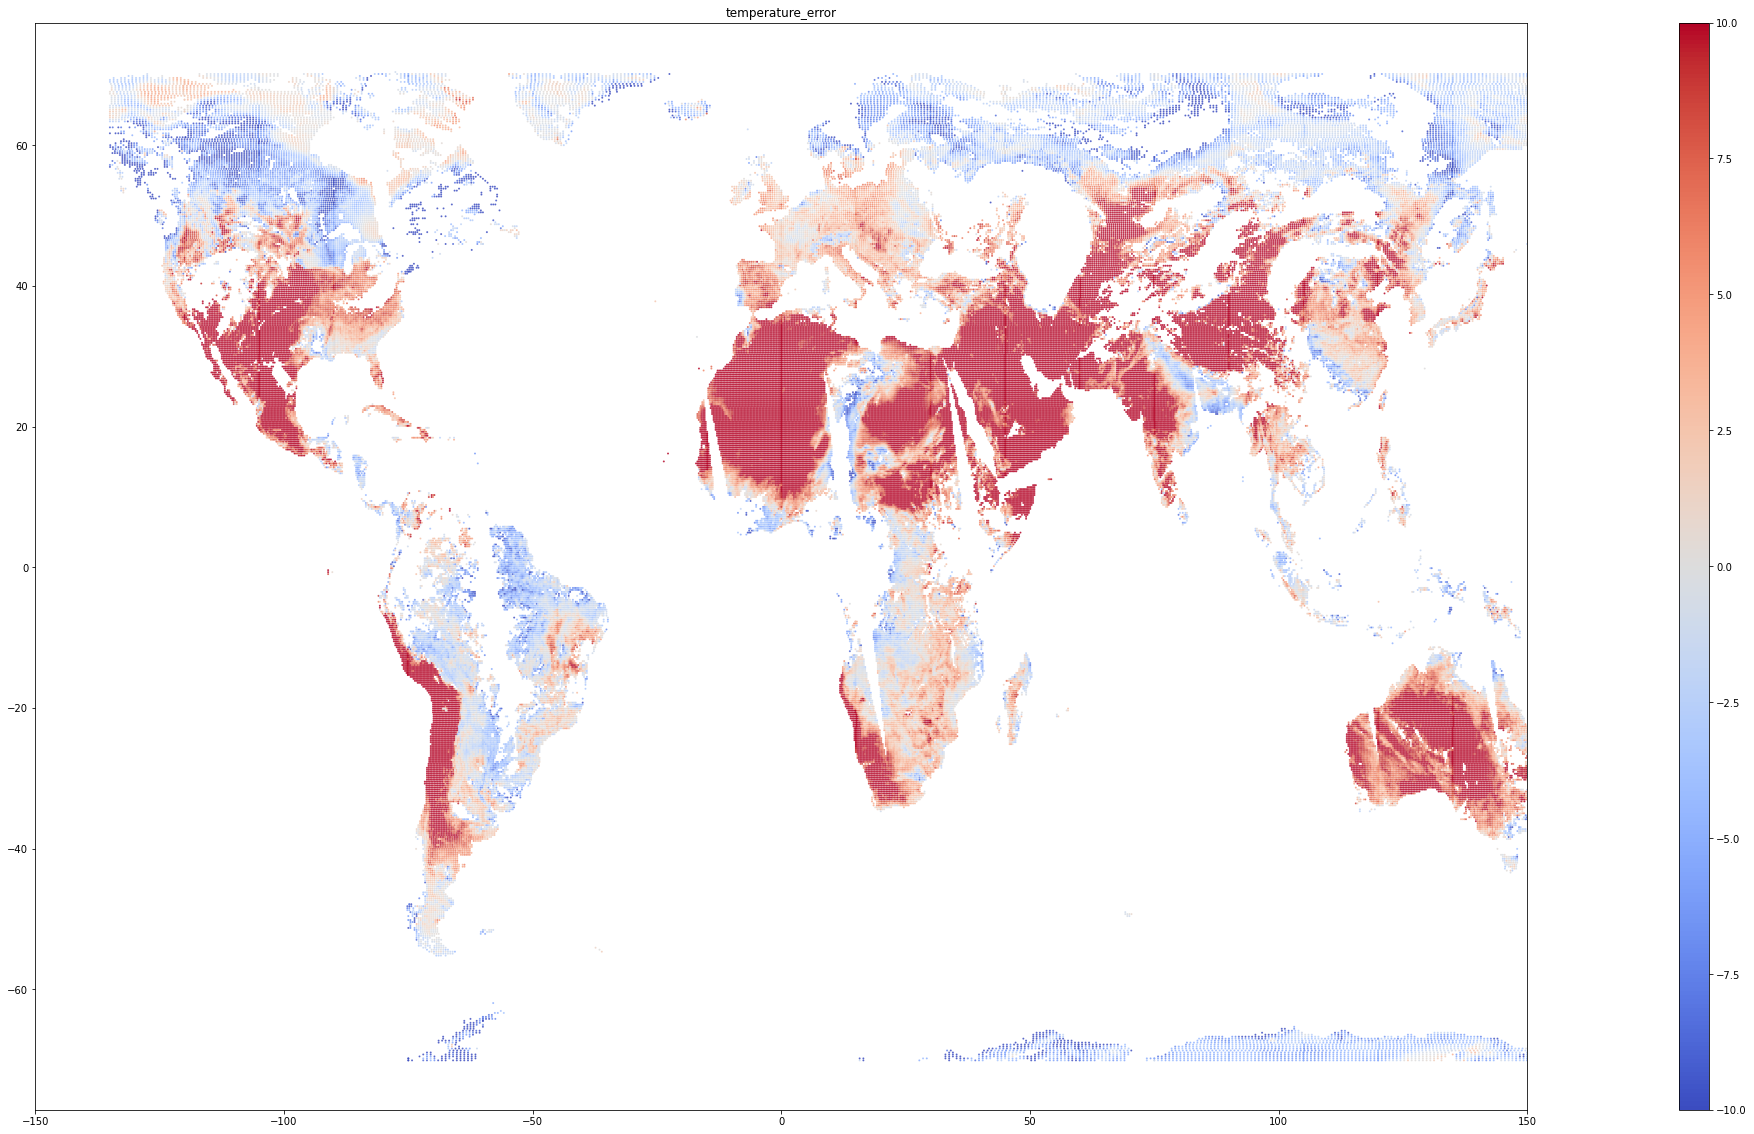

In [43]:

print ('Mean absolute error:',df1.temperature_error_abs.mean())
print ('Median absolute error:',df1.temperature_error_abs.median())

plot_error(df1,'temperature_error', vmin=-10, vmax=+10, cmap=plt.cm.coolwarm)



Now lets use our new dataset:

In [44]:
dfs = []


for i in range(2,23):
    print(i)
    df = pipeline(date,i,'new')
    dfs.extend([df])

    
df2 = pd.concat(dfs)


2
find matches
3
find matches
4
find matches
5
find matches
6
find matches
7
find matches
8
find matches
9
find matches
10
find matches
11
find matches
12
find matches
13
find matches
14
find matches
15
find matches
16
find matches
17
find matches
18
find matches
19
find matches
20
find matches
21
find matches
22
find matches


Mean absolute error: 6.265212
Median absolute error: 4.527878


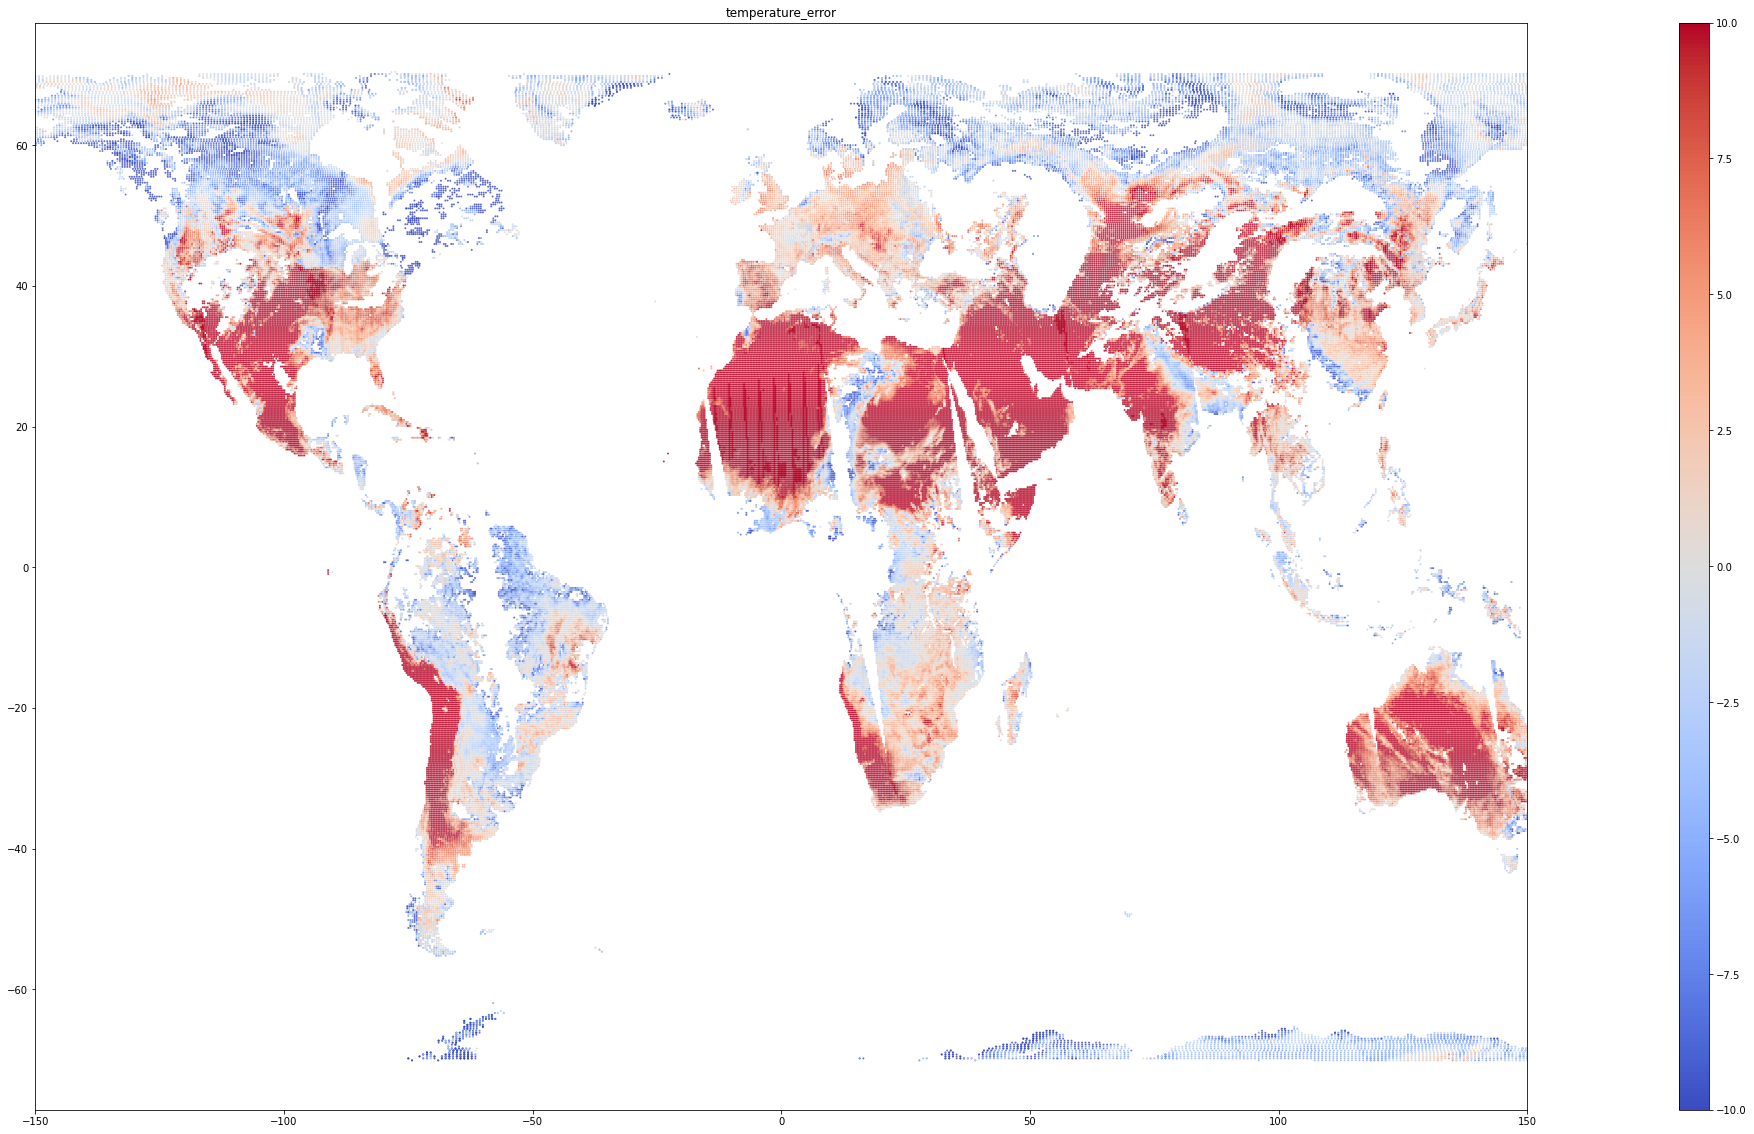

In [46]:
print ('Mean absolute error:',df2.temperature_error_abs.mean())
print ('Median absolute error:',df2.temperature_error_abs.median())

plot_error(df2,'temperature_error', vmin=-10, vmax=+10, cmap=plt.cm.coolwarm)



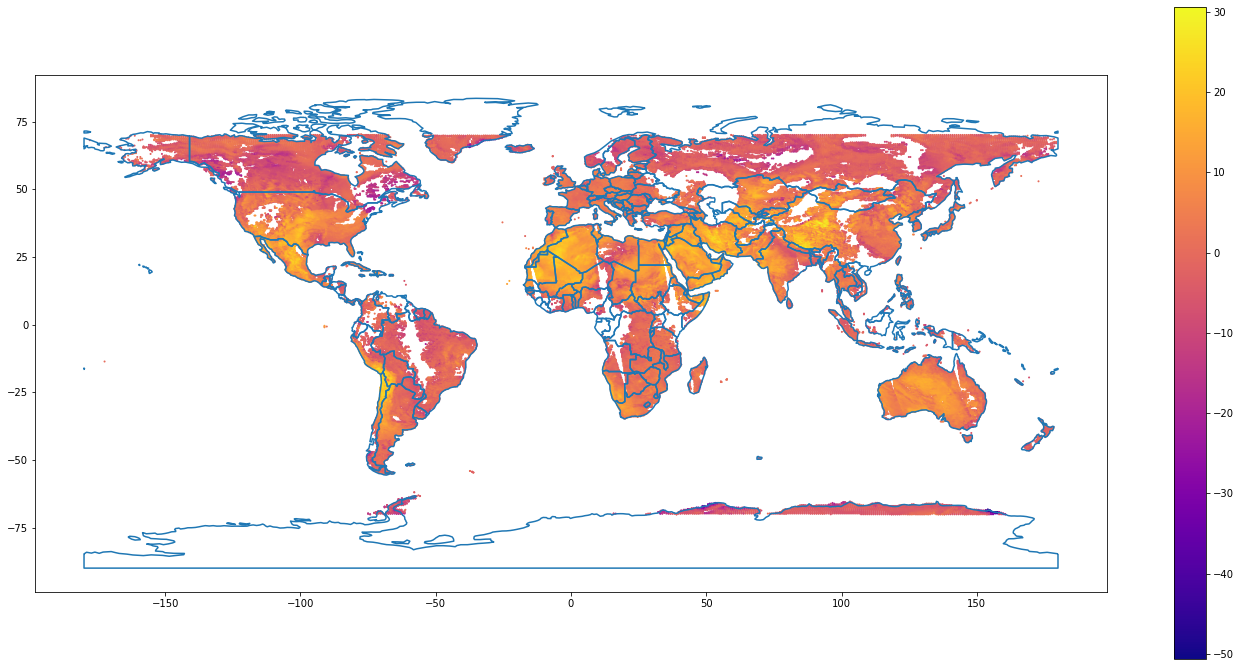

In [47]:
plot_map(df2,'longitude_ERA','latitude_ERA','temperature_error')

In [84]:
dfs = []


for i in range(2,23):
    print(i)
    df = pipeline(date,i,'new',quality_filter=True)
    dfs.extend([df])

    
df3 = pd.concat(dfs)



2
Applying quality filter
Getting ERA data
{'latitude_min': -44.82500000000002, 'latitude_max': 70.975, 'longitude_min': -177.575, 'longitude_max': 179.72500000000005}
ERA_sfc
ERA_skin
ERA_merge
ERA_filter
find matches
3
Applying quality filter
Getting ERA data
{'latitude_min': -70.62500000000003, 'latitude_max': 59.02499999999999, 'longitude_min': 139.525, 'longitude_max': 175.17500000000004}
ERA_sfc
ERA_skin
ERA_merge
ERA_filter
find matches
4
Applying quality filter
Getting ERA data
{'latitude_min': -70.97500000000002, 'latitude_max': 70.975, 'longitude_min': 95.975, 'longitude_max': 167.37500000000003}
ERA_sfc
ERA_skin
ERA_merge
ERA_filter
find matches
5
Applying quality filter
Getting ERA data
{'latitude_min': -70.97500000000002, 'latitude_max': 70.975, 'longitude_min': 69.57500000000002, 'longitude_max': 163.72500000000005}
ERA_sfc
ERA_skin
ERA_merge
ERA_filter
find matches
6
Applying quality filter
Getting ERA data
{'latitude_min': -70.97500000000002, 'latitude_max': 70.975, 'lo

In [85]:
df3

latitude_ERA  longitude_ERA       level_0   index_MODIS  latitude_MODIS  \
0       -43.419187        172.500  82154.000000  1.920225e+07      -43.325000   
1       -43.138157        172.125  82053.000000  1.916624e+07      -43.075000   
2       -43.138157        172.500  82109.692308  1.918342e+07      -43.194231   
3       -42.857127        171.750  82003.000000  1.915184e+07      -42.975000   
4       -42.857127        172.125  82004.000000  1.915184e+07      -42.975000   
...            ...            ...           ...           ...             ...   
1237     69.836018       -161.250    550.000000  2.901970e+06       69.825000   
1238     69.836018       -155.250    376.225806  2.895593e+06       69.870161   
1239     69.836018       -154.500    730.166667  2.906607e+06       69.793750   
1240     69.836018       -149.250   1135.000000  2.916619e+06       69.725000   
1241     69.836018       -128.250    265.000000  2.888229e+06       69.925000   

      longitude_MODIS  QC_Day   MODIS_LST  index_ERA    values  ...      anor  \
0          172.325000     8.0  287.519989   437123.0  437123.0  ... -1.449098   
1          172.025000     8.0  283.019989   436169.0  436169.0  ... -0.512213   
2          172.444231     8.0  288.036926   436170.0  436170.0  ... -1.322489   
3          171.925000     8.0  280.479980   435215.0  435215.0  ... -1.322948   
4          171.975000     8.0  280.479980   435216.0  435216.0  ... -0.268078   
...               ...     ...         ...        ...       ...  ...       ...   
1237      -161.475000     8.0  258.339996      239.0     239.0  ...  1.058059   
1238      -155.152419     8.0  258.037415      247.0     247.0  ... -0.611362   
1239      -154.622917     8.0  258.201660      248.0     248.0  ...  0.422744   
1240      -149.025000     8.0  255.239990      255.0     255.0  ...  0.908596   
1241      -128.525000     8.0  249.720001      283.0     283.0  ...  0.514823   

          slor         d2m       lsm       fal  L2_distance  MODIS_idx  \
0     0.006491  281.056213  0.999272  0.159430     0.042969   137440.0   
1     0.044664  278.503479  0.999933  0.114508     0.011719   137405.0   
2     0.020920  280.097229  1.000000  0.136923     0.014123   137406.0   
3     0.045265  277.946838  0.999298  0.193579     0.044922   137369.0   
4     0.037417  278.079651  0.997231  0.134802     0.037109   137370.0   
...        ...         ...       ...       ...          ...        ...   
1237  0.002077  257.224304  0.990949  0.667540     0.053385       58.0   
1238  0.002273  256.609070  0.993495  0.626860     0.047631       66.0   
1239  0.001954  256.538757  0.983633  0.630018     0.040283       67.0   
1240  0.001390  255.169617  0.991854  0.622465     0.065104       74.0   
1241  0.003904  248.064148  0.931557  0.581526     0.087891       86.0   

      H_distance  temperature_error  temperature_error_abs  
0      17.600219          -5.411682               5.411682  
1      10.734211          -3.778870               3.778870  
2      10.028755          -2.459198               2.459198  
3      19.361810          -1.410675               1.410675  
4      17.916448          -2.199738               2.199738  
...          ...                ...                    ...  
1237    8.715939          -2.280182               2.280182  
1238   10.168918          -1.028076               1.028076  
1239   11.043742          -0.762268               0.762268  
1240   15.126730          -2.909485               2.909485  
1241   14.562502          -2.279099               2.279099  

[77520 rows x 40 columns]

Mean absolute error: 7.3974686
Median absolute error: 5.732437


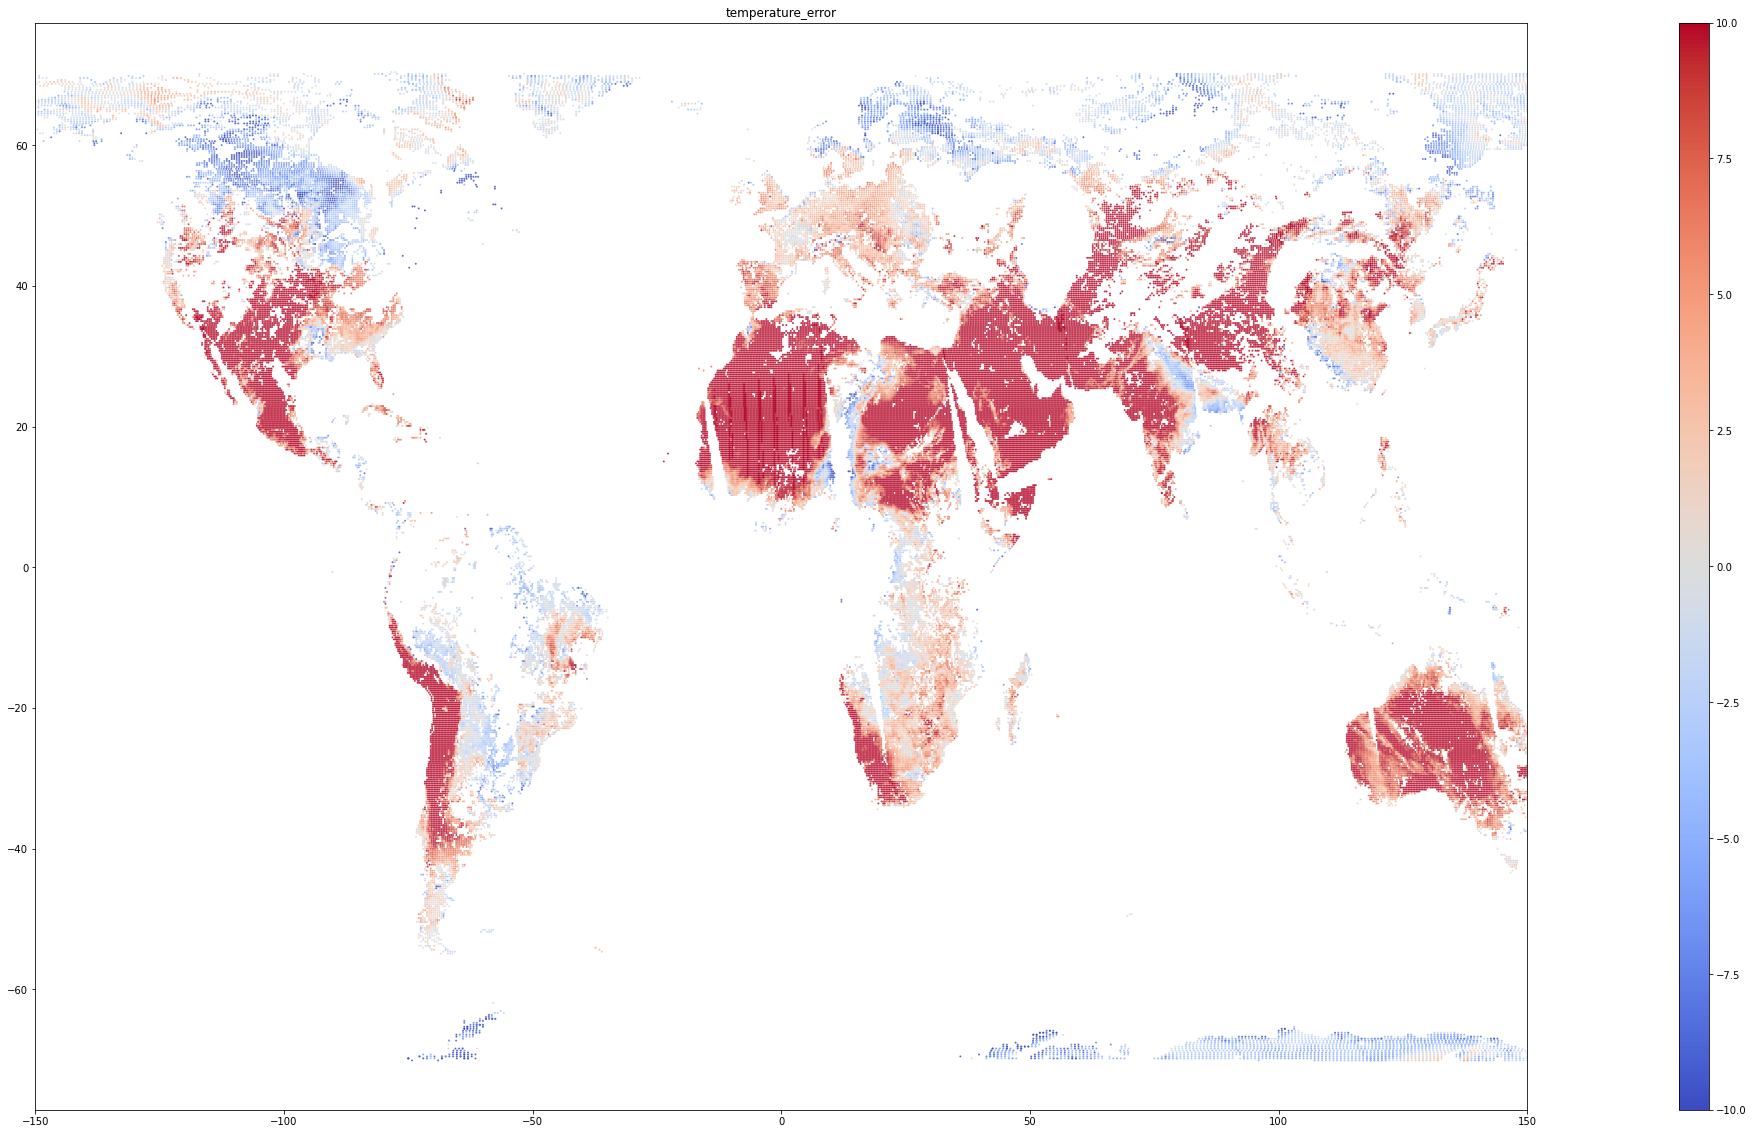

In [86]:
print ('Mean absolute error:',df3.temperature_error_abs.mean())
print ('Median absolute error:',df3.temperature_error_abs.median())

plot_error(df3,'temperature_error', vmin=-10, vmax=+10, cmap=plt.cm.coolwarm)


